In [1]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import pickle
from datetime import datetime
from sklearn.metrics import ConfusionMatrixDisplay
from ipynb.fs.defs.Prepare_Data import train_test_val
from ipynb.fs.defs.Prepare_Data import load_csv_into_df
from ipynb.fs.defs.Prepare_Data import combine_dataframes
from ipynb.fs.defs.Feature_Engineering import preprocess_dataset
from ipynb.fs.defs.Data_Augmentation import data_augmentation
from config import lgbm_params
from config import lgbm_hyperparameter as lgbm_hp

In [2]:
def store_predictions(model, X_test, y_test, y_pred, features, timestamp):
    vectorizer_path = f"../models/vectorizer_{timestamp}.pkl"
    # Load the vectorizer from the file
    with open(vectorizer_path, 'rb') as f:
        vectorizer = pickle.load(f)

    vocabulary_path = f"../models/vocabulary_{timestamp}.pkl" 
    # Get the vocabulary of the training data
    with open(vocabulary_path, 'rb') as f:
        vocabulary = pickle.load(f)
        
    
    probabilities = model.predict_proba(X_test)

    # Extrahieren der wichtigsten Features
    boost = model.booster_
    importance = boost.feature_importance()
    feature_names = boost.feature_name()
    sorted_idx = np.argsort(importance)[::-1]

    feature_dict = {vocabulary.shape[0]+index: key for index, key in enumerate(features)}

    true_label = y_test.reset_index(drop=True)

    X_test_restored = vectorizer.inverse_transform(X_test[:,:vocabulary.shape[0]-len(features)])
    original_designation = [' '.join(words) for words in X_test_restored]

    # Ausgabe der Vorhersagen, der Wahrscheinlichkeiten und der wichtigsten Features
    for i in range(len(X_test)):
        print('Vorhersage für Sample {}: {}'.format(i+1, y_pred[i]), 'True: {}'.format(true_label[i]))
        print(original_designation[i])

        print('Wahrscheinlichkeit für Sample {}: {}'.format(i+1, probabilities[i][1]))
        if y_pred[i] == 0 and true_label[i] == 1:
            print('Wichtigste Features für Sample {}:'.format(i+1))
            for j in sorted_idx:
                if importance[j] > 0:
                    if j < vocabulary.shape[0]:
                        print('{} ({}) Value: {}'.format(feature_names[j], importance[j], vocabulary[j]))
                    else:
                        print('{} ({}) Value: {}'.format(feature_names[j], importance[j], feature_dict[j]))
                else:
                    continue
        print('------------------------')

In [3]:
def load_prepare_dataset(folder_path, augmentation):
    dataframes_list = load_csv_into_df(folder_path, original_prisma_data=False, move_to_archive=False)
    df_combined = combine_dataframes(dataframes_list)
    df_preprocessed, df_for_plot = preprocess_dataset(df_combined, cut_percent_of_front=lgbm_params["cut_percent_of_front"])

    if augmentation:
        # Declare which data augmentation techniques should be used
        rand_order = True
        rand_mistakes = True
        gpt = True

        # Generate the new dataset
        df_preprocessed = data_augmentation(df_preprocessed, rand_order, rand_mistakes, gpt, df_to_excel = False)

    weight_factor = round(df_preprocessed[df_preprocessed["Relevant fuer Messung"]=="Nein"].shape[0] / df_preprocessed[df_preprocessed["Relevant fuer Messung"]=="Ja"].shape[0])

    dateTimeObj = datetime.now()
    timestamp = dateTimeObj.strftime("%d%m%Y_%H%M")

    # Split dataset
    X_train, y_train, X_val, y_val, X_test, y_test, features = train_test_val(df_preprocessed, test_size=lgbm_params["test_size"], timestamp=timestamp)

    return X_train, y_train, X_val, y_val, X_test, y_test, features, weight_factor, timestamp

In [4]:
def train_model(X_train, y_train, X_val, y_val, weight_factor):
    
    class_weight = {0: 1, 1: weight_factor}
    evals = {}
    callbacks = [lgb.early_stopping(10), lgb.record_evaluation(evals)]

    gbm = LGBMClassifier(objective='binary',
                        metric=lgbm_params["metrics"],
                        num_leaves=lgbm_hp["num_leaves"],
                        learning_rate=lgbm_hp["lr"],
                        feature_fraction=lgbm_hp["feature_fraction"],
                        n_estimators=lgbm_params["n_estimators"],
                        class_weight=class_weight)

    gbm.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)], 
            eval_metric=lgbm_params["metrics"],
            early_stopping_rounds=lgbm_params["early_stopping"],
            callbacks=callbacks)

    
    return gbm, evals


In [5]:
def store_trained_model(model, timestamp):
    # save model
    model_path = f"../models/lgbm_{timestamp}.pkl"
    with open(model_path, "wb") as filestore:
        pickle.dump(model, filestore)

In [6]:
def evaluate_model(model, X_test, y_test, evals):
    y_pred = model.predict(X_test)
    y_pred = np.round(y_pred)

    # Print accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    print("\n\n Test accuracy:", accuracy)

    lgb.plot_metric(evals, metric='binary_logloss')
    lgb.plot_metric(evals, metric='auc')

    class_names = ["Nein", "Ja"]
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=class_names, cmap='Blues', colorbar=False)

    return y_pred

2023-05-12 18:53:23.960 | INFO     | ipynb.fs.defs.Prepare_Data:load_csv_into_df:34 - Loading the data...
2023-05-12 18:53:33.932 | SUCCESS  | ipynb.fs.defs.Prepare_Data:load_csv_into_df:68 - 4 dataframe(s) were created.
2023-05-12 18:53:52.932 | SUCCESS  | ipynb.fs.defs.Prepare_Data:combine_dataframes:91 - 4 dataframe(s) are combined to one dataset and stored in a excel file.
2023-05-12 18:53:52.933 | INFO     | ipynb.fs.defs.Feature_Engineering:preprocess_dataset:199 - Start preprocessing the dataframe with 15849 samples...
2023-05-12 18:54:04.331 | SUCCESS  | ipynb.fs.defs.Feature_Engineering:preprocess_dataset:255 - The dataset is successfully preprocessed. The new dataset contains 2625 samples
2023-05-12 18:54:04.333 | INFO     | ipynb.fs.defs.Data_Augmentation:data_augmentation:194 - Start adding artificial designations...
2023-05-12 18:55:05.827 | SUCCESS  | ipynb.fs.defs.Data_Augmentation:data_augmentation:237 - Creating a new dataset with artificial designations was succeccful

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[66]	training's auc: 1	training's binary_logloss: 0.0593933	valid_1's auc: 0.995536	valid_1's binary_logloss: 0.100724


 Test accuracy: 0.9752066115702479
Vorhersage für Sample 1: 0 True: 0
 mi  mit  mitt  mo  mot  moto  st  sti  stir and and  and m aum aum  aum m d m d mo d mot i s i st i sti irn irnw irnwa itt itte m m m mi m mit mit mitt mitte mot moto motor nd  nd m nd mo nwa nwan nwand orr orra orrau oto otor otorr rau raum raum  rnw rnwa rnwan rra rrau rraum si  si s si st sti stir stirn tir tirn tirnw tor torr torra tte um  um m um mi wan wand wand 
Wahrscheinlichkeit für Sample 1: 0.05698855133020699
------------------------
Vorhersage für Sample 2: 0 True: 0
 ha  hal  halt  va  vas  vas  alt alte altel as  as h as ha e 2 eis eist eiste ele elei eleis hal halt 

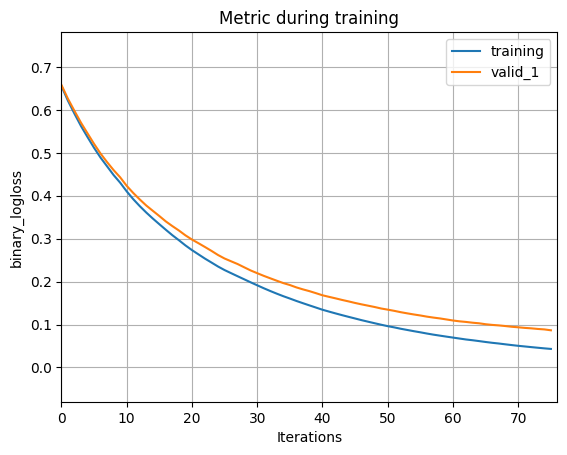

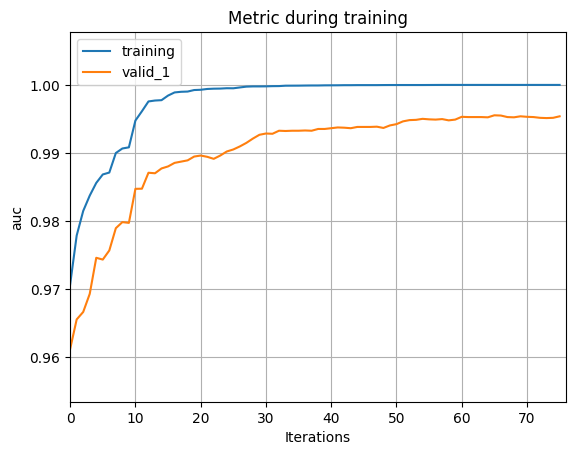

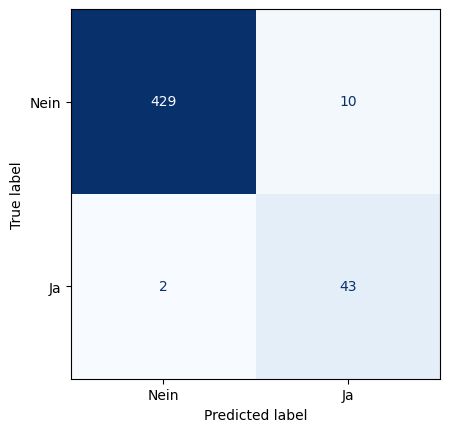

In [7]:
# Split dataset
folder_path = "../data/labeled_data/"
store_model = True
store_preds = True

X_train, y_train, X_val, y_val, X_test, y_test, features, weight_factor, timestamp = load_prepare_dataset(folder_path, augmentation=True)
gbm, evals = train_model(X_train, y_train, X_val, y_val, weight_factor)
y_pred = evaluate_model(gbm, X_test, y_test, evals)

if store_preds:
    store_predictions(gbm, X_test, y_test, y_pred, features, timestamp)

if store_model:
    store_trained_model(gbm, timestamp)
